In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
target_snr_per_bin = 15 # 13 and 15

velocity_realizations = None
sample_number_for_each_setting = 1000

for rng in range(1, 4):
    for deg in range(2, 5):
        for template in range(1, 4):
            for quasar in ['A', 'B', 'C']:
                
                vd_name = 'VD_wave_rng_{}_deg_{}_global_temp_{}_quasar_sp_{}_SN_{}.txt'.format(
                    rng, deg, template, quasar, target_snr_per_bin
                )

                directory_measurements = "../kcwi_extractions/extracted_dispersions/"
                # object_name = "KCWI_RXJ1131_icubes_mosaic_0.1457"

                url = directory_measurements + vd_name

                extracted_vel_dis = np.loadtxt(url)
                
                vel = extracted_vel_dis[:, 0]
                std_vel = extracted_vel_dis[:, 2]
                
                vel_dis = extracted_vel_dis[:, 1]
                std_vel_dis = extracted_vel_dis[:, 3]
                
                good_bins = np.ones_like(vel_dis)
                
                if np.any(std_vel_dis > 200):
#                     print(vel_dis[std_vel_dis > 200], std_vel_dis[std_vel_dis > 200])
                    good_bins[std_vel_dis > 200] = 0
                    good_bins[std_vel_dis > 200] = 0
                
                min_val = 5
                if np.any(vel_dis < min_val):
#                     print(vel_dis[vel_dis < min_val], std_vel_dis[vel_dis < min_val])
                    good_bins[vel_dis < min_val] = 0
                    good_bins[vel_dis < min_val] = 0
                
                max_val = 700
                if np.any(vel_dis > max_val):
#                     print(vel_dis[vel_dis > max_val], std_vel_dis[vel_dis > max_val])
                    good_bins[vel_dis > max_val] = 0
                    good_bins[vel_dis > max_val] = 0
                    
                
                realizations = np.random.normal(loc=vel[np.newaxis, :],
                                         scale=std_vel[np.newaxis, :],
                                         size=(sample_number_for_each_setting, len(vel))
                                        )

                realizations[:, np.where(good_bins == 0)] = np.nan
                
                if velocity_realizations is None:
                    velocity_realizations = realizations 
                else:
                    velocity_realizations = np.append(velocity_realizations, 
                                                                 realizations, axis=0)
            
print(velocity_realizations.shape)    

(81000, 121)


Text(0.5, 1.0, 'velocity in each bin')

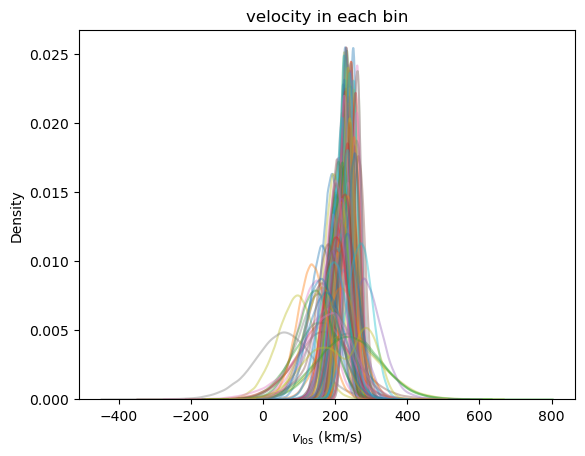

In [4]:
import seaborn as sns

ax = plt.figure().add_subplot(111)

for i in range(velocity_realizations.shape[1]):
    sns.kdeplot(velocity_realizations[:, i][velocity_realizations[:, i] != np.nan], 
                ax=ax, alpha=0.4)

ax.set_xlabel(r'$v_{\rm los}$ (km/s)')
ax.set_title('velocity in each bin')

In [5]:
import numpy.ma as ma


covariance_matrix = ma.cov(ma.masked_invalid(velocity_realizations), rowvar=False)

covariance_matrix.filled(np.inf);

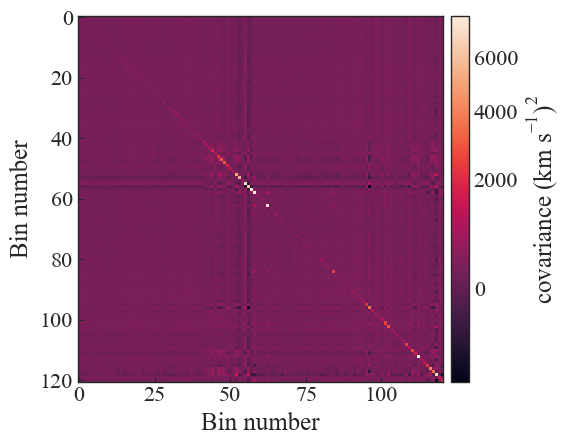

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import simple_norm
import paperfig as pf

pf.set_fontscale(2.)

norm = simple_norm(covariance_matrix, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((covariance_matrix), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

fig.tight_layout()

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_dispersion_covariance.pdf', 
#             bbox_inches='tight'
#            )

In [7]:
mean = ma.mean(ma.masked_invalid(velocity_realizations), axis=0).data

mean.shape

(121,)

In [10]:
# import h5py
# import pickle


# with h5py.File('./data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}.h5'.format(target_snr_per_bin), 
#                'w') as f:
#     f.create_dataset('mean', data=mean)
#     f.create_dataset('covariance', data=covariance_matrix)
    
# with open('./data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}.pickle'.format(target_snr_per_bin), 
#                'wb') as f:
#     pickle.dump({'mean': mean, 'covariance': covariance_matrix}, f)
    
np.savetxt('./data_products/systematic_marginalized_velocity_snr_per_bin_{}_mean.txt'.format(target_snr_per_bin), mean)
np.savetxt('./data_products/systematic_marginalized_velocity_snr_per_bin_{}_covariance.txt'.format(target_snr_per_bin), covariance_matrix)

# np.savetxt('./data_products/velcity_dispersion_binned_mean_snr_per_bin_{}.txt'.format(snr), mean)
# np.savetxt('./data_products/velcity_dispersion_binned_covmat_snr_per_bin_{}.txt'.format(snr), covariance_matrix)

In [8]:
from data_util import *

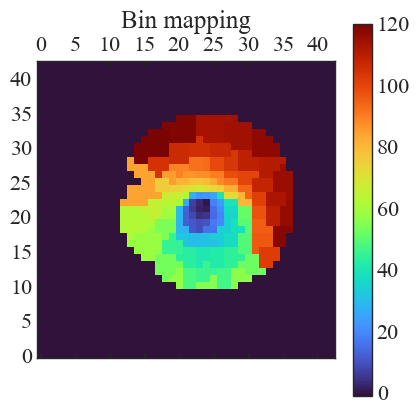

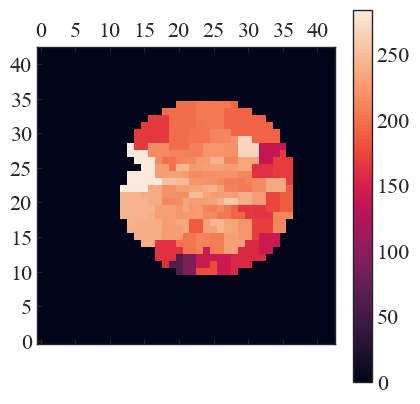

In [9]:
%matplotlib inline

bin_mapping = load_bin_mapping(target_snr_per_bin=target_snr_per_bin, 
                               plot=True)

im = plt.matshow(get_kinematics_maps(mean, bin_mapping), origin='lower') #, vmax=400, vmin=50)
plt.colorbar(im)